In [1]:
#导入库和读取数据
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

os.makedirs("figures", exist_ok=True)
train_data = pd.read_csv("data/Titanic-train.csv")
test_data = pd.read_csv("data/Titanic-test.csv")

In [2]:
#缺失值处理和特征工程
##核对缺失值
'''
print(train_data.isnull().sum())
print(test_data.isnull().sum())
'''
train_data['Age']=train_data['Age'].fillna(train_data['Age'].median())
test_data['Age']=test_data['Age'].fillna(test_data['Age'].median())
train_data['Title']=train_data['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
test_data['Title']=test_data['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)

def process_cabin(df):
    df['Cabin']=df['Cabin'].fillna('M')#缺失值统一用'M'表示
    df['CabinLetter']=df['Cabin'].apply(lambda x:x[0])
    return df 

train_data=process_cabin(train_data)
test_data=process_cabin(test_data)

print(train_data[['Name','Title','Cabin']].head())
train_data['Embarked']=train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
test_data['Embarked']=test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])
test_data['Fare']=test_data['Fare'].fillna(test_data['Fare'].median())

##构造Familysize特征工程
train_data['FamilySize']=train_data['SibSp']+train_data['Parch']+1
test_data['FamilySize']=test_data['SibSp']+test_data['Parch']+1

#title分组映射
title_map={ 
           "Mr":"Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Dr": "Officer", "Rev": "Officer", "Col": "Officer", "Major": "Officer",
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs", "Don": "Royalty",
    "Countess": "Royalty", "Lady": "Royalty", "Sir": "Royalty", "Jonkheer": "Royalty", "Capt": "Officer"
    }
train_data['Title']=train_data['Title'].map(title_map).fillna('Other')
test_data['Title']=test_data['Title'].map(title_map).fillna('Other')

                                                Name Title Cabin
0                            Braund, Mr. Owen Harris    Mr     M
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   Mrs   C85
2                             Heikkinen, Miss. Laina  Miss     M
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   Mrs  C123
4                           Allen, Mr. William Henry    Mr     M


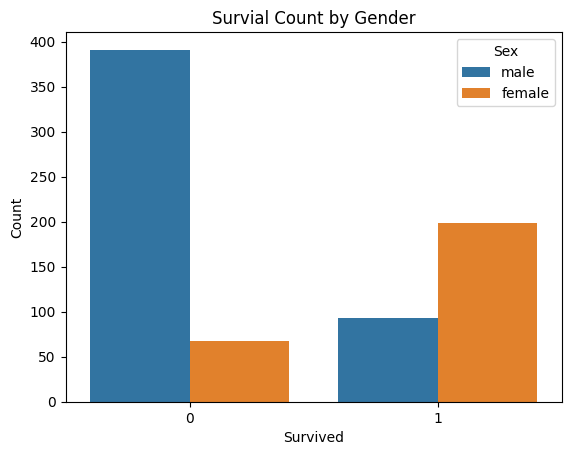

In [3]:
#可视化分析
##生还与性别关系图
sns.countplot(x='Survived',hue='Sex',data=train_data)#生还与性别条形图
plt.title('Survial Count by Gender')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.savefig("figures/gender_survival.png", dpi=300)
plt.show()

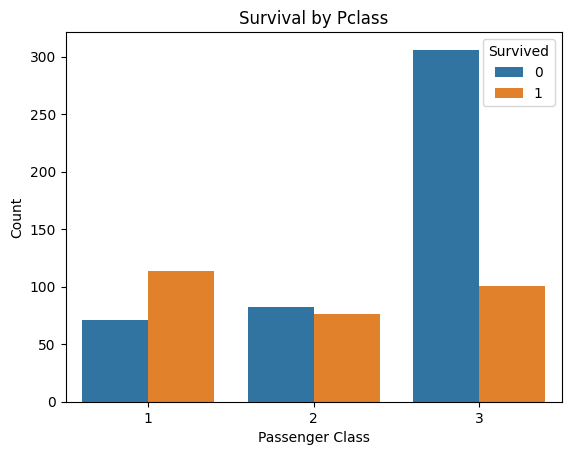

In [4]:
##生还与仓位等级
sns.countplot(x='Pclass',hue='Survived',data=train_data)
plt.title('Survival by Pclass')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()

C:\Users\leahf\AppData\Local\Temp\ipykernel_59792\1478933492.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_data[train_data['Survived']==1]['Age'],label='Survived',shade=True)
C:\Users\leahf\AppData\Local\Temp\ipykernel_59792\1478933492.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_data[train_data['Survived']==0]['Age'],label='Not Survived',shade=True)


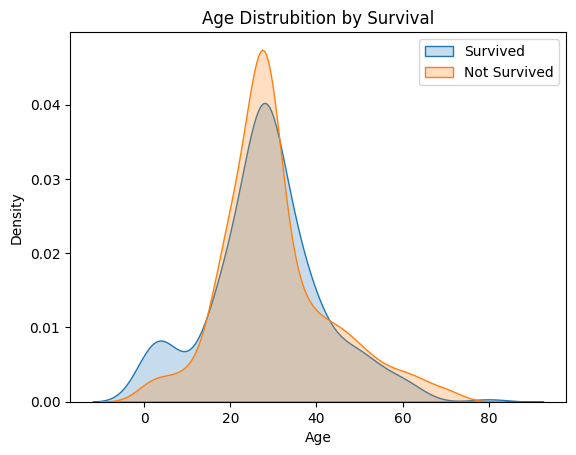

In [5]:
##Age分布密度图
sns.kdeplot(train_data[train_data['Survived']==1]['Age'],label='Survived',shade=True)
sns.kdeplot(train_data[train_data['Survived']==0]['Age'],label='Not Survived',shade=True)
plt.title('Age Distrubition by Survival')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

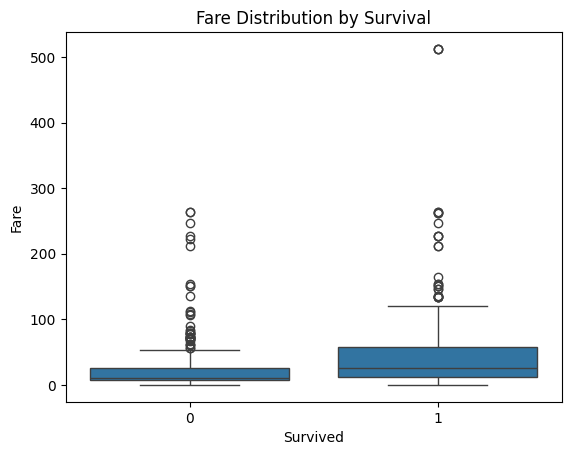

In [6]:
##fare分布箱线图
sns.boxplot(x='Survived',y='Fare',data=train_data)
plt.title('Fare Distribution by Survival')
plt.xlabel('Survived')
plt.ylabel('Fare')
plt.show()

In [7]:
#建模与结果评估
y=train_data['Survived']
X=train_data.drop(['Survived','Name','Ticket','Cabin'],axis=1)
X=pd.get_dummies(X)

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_val)
print('Accuracy:',accuracy_score(y_val,y_pred))
print('Confusion Matric:\n',confusion_matrix(y_val,y_pred))
print('Classification Report:\n',classification_report(y_val,y_pred))

Accuracy: 0.8066666666666666
Confusion Matric:
 [[72 10]
 [19 49]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83        82
           1       0.83      0.72      0.77        68

    accuracy                           0.81       150
   macro avg       0.81      0.80      0.80       150
weighted avg       0.81      0.81      0.80       150



D:\Anaconda\envs\stock\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
#模型对比：随机森林和knn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
rf=RandomForestClassifier(random_state=42)
knn=KNeighborsClassifier()
models={'Logistic Regression':logreg,'Random Forest':rf,'KNN':knn}
for name,model in models.items():
    model.fit(X_train,y_train)
    score=model.score(X_val,y_val)
    print(f'{name}:Accuracy={score:.4f}')

D:\Anaconda\envs\stock\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:Accuracy=0.8067
Random Forest:Accuracy=0.8133
KNN:Accuracy=0.6267


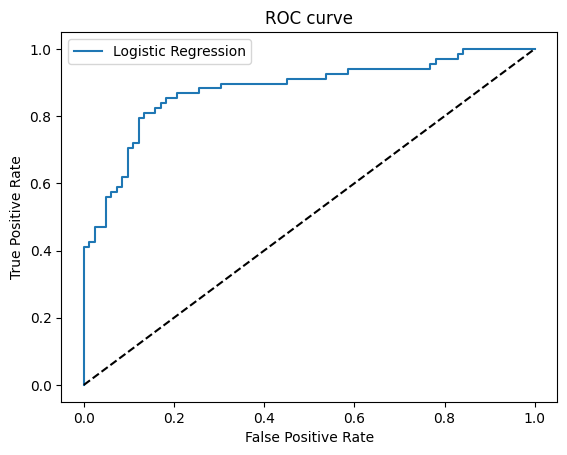

AUC: 0.8794835007173601


In [9]:
#AUC和ROC曲线评估
from sklearn.metrics import roc_auc_score,roc_curve
y_prob=logreg.predict_proba(X_val)[:,1]
fpr,tpr,thresholds=roc_curve(y_val,y_prob)
plt.plot(fpr,tpr,label='Logistic Regression')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("figures/roc_curve.png", dpi=300)
plt.show()
print('AUC:',roc_auc_score(y_val,y_prob))

In [10]:
#预测并生成文件
test_data_encoded = pd.get_dummies(test_data)
test_data_encoded = test_data_encoded.reindex(columns=X.columns, fill_value=0)

test_pred = logreg.predict(test_data_encoded)

submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_pred
})

submission.to_csv("submission.csv", index=False)
print("submission.csv已生成")


submission.csv已生成
